In [1]:
!pip install gym
!pip install stable-baselines3
!pip install yfinance
!pip install numpy


  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


In [2]:
import yfinance as yf

# Download stock market data
nvidia_data = yf.download('NVDA', start='2020-01-01', end='2024-06-22', interval='1d')
nvidia_data = nvidia_data[['Close']]
print(nvidia_data.head())


[*********************100%%**********************]  1 of 1 completed

              Close
Date               
2020-01-02  5.99775
2020-01-03  5.90175
2020-01-06  5.92650
2020-01-07  5.99825
2020-01-08  6.00950


In [8]:
import gym
from gym import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, render_mode=None):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.render_mode = render_mode
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.holdings = 0
        self.done = False
        return np.array([self.df['Close'].iloc[self.current_step]])

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode is done. Reset the environment to start a new episode.")

        current_price = self.df['Close'].iloc[self.current_step]

        if action == 1:  # Buy
            self.holdings += self.balance // current_price
            self.balance %= current_price
        elif action == 2:  # Sell
            self.balance += self.holdings * current_price
            self.holdings = 0

        self.current_step += 1

        if self.current_step >= len(self.df):
            self.done = True
            reward = self.balance + self.holdings * current_price - 10000
        else:
            next_price = self.df['Close'].iloc[self.current_step]
            reward = self.balance + self.holdings * next_price - 10000

        if self.render_mode == 'human':
            self.render()

        return np.array([self.df['Close'].iloc[min(self.current_step, len(self.df) - 1)]]), reward, self.done, {}

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f"Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.holdings}")


In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Prepare the environment
env = DummyVecEnv([lambda: StockTradingEnv(nvidia_data)])

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the model
model.save("ppo_stock_trading")


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 782  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 660          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.339986e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 1.43e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.25e+10     |
|    n_updates            | 10           |
|    policy_gradient_loss | -1.38e-05    |
|    value_loss           | 3.92e+10     |
------------------------------------------

In [12]:
# Load the trained model
model = PPO.load("ppo_stock_trading")
total_reward=0
# Test the model
obs = env.reset()
for i in range(len(nvidia_data)):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    total_reward+=rewards
    env.render()
    if done:
        print(f"Total Test Reward: {total_reward}")
        break


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Total Test Reward: [24720058.]


In [16]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, render_mode=None):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.render_mode = render_mode
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.holdings = 0
        self.done = False
        self.history = []
        return np.array([self.df['Close'].iloc[self.current_step]])

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode is done. Reset the environment to start a new episode.")

        current_price = self.df['Close'].iloc[self.current_step]

        if action == 1:  # Buy
            self.holdings += self.balance // current_price
            self.balance %= current_price
        elif action == 2:  # Sell
            self.balance += self.holdings * current_price
            self.holdings = 0

        self.current_step += 1
        if self.current_step >= len(self.df):
            self.done = True
            reward = self.balance + self.holdings * current_price - 10000
            self.current_step = len(self.df) - 1  # Ensure valid index
        else:
            next_price = self.df['Close'].iloc[self.current_step]
            reward = self.balance + self.holdings * next_price - 10000

        self.history.append({
            'balance': self.balance,
            'holdings': self.holdings,
            'price': current_price,
            'total_value': self.balance + self.holdings * current_price
        })

        if self.render_mode == 'human':
            self.render()

        return np.array([self.df['Close'].iloc[self.current_step]]), reward, self.done, {}

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f"Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.holdings}, Total Value: {self.balance + self.holdings * self.df['Close'].iloc[self.current_step]}")

# Prepare the environment
env = DummyVecEnv([lambda: StockTradingEnv(nvidia_data, render_mode='human')])

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the model
model.save("ppo_stock_trading")

# Load the trained model
model = PPO.load("ppo_stock_trading")

# Test the model
obs = env.reset()
total_reward = 0
history = []

for _ in range(len(nvidia_data)):
    action, _states = model.predict(obs)
    obs, rewards, done, _ = env.step(action)
    total_reward += rewards
    if env.get_attr('history')[0]:  # Check if history is not empty
        history.append(env.get_attr('history')[0][-1])  # Get the last history record
    if done:
        print(f"Total Test Reward: {total_reward}")
        break

# Convert history to DataFrame
history_df = pd.DataFrame(history)

# Calculate additional metrics
returns = history_df['total_value'].pct_change().dropna()
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
volatility = returns.std() * np.sqrt(252)
max_drawdown = history_df['total_value'].min()
sortino_ratio = returns.mean() / returns[returns < 0].std() * np.sqrt(252)
calmar_ratio = returns.mean() / max_drawdown * np.sqrt(252)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Volatility: {volatility}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Calmar Ratio: {calmar_ratio}")


Streaming output truncated to the last 5000 lines.
Step: 9, Balance: 1.4063191413879395, Holdings: 1691.0, Total Value: 10382.877733707428
Step: 10, Balance: 10382.877733707428, Holdings: 0, Total Value: 10382.877733707428
Step: 11, Balance: 2.496880054473877, Holdings: 1668.0, Total Value: 10397.472670078278
Step: 12, Balance: 10397.472670078278, Holdings: 0, Total Value: 10397.472670078278
Step: 13, Balance: 2.5879077911376953, Holdings: 1677.0, Total Value: 10488.449523448944
Step: 14, Balance: 2.5879077911376953, Holdings: 1677.0, Total Value: 10603.743113517761
Step: 15, Balance: 2.5879077911376953, Holdings: 1677.0, Total Value: 10503.962048530579
Step: 16, Balance: 2.5879077911376953, Holdings: 1677.0, Total Value: 10072.973099708557
Step: 17, Balance: 2.5879077911376953, Holdings: 1677.0, Total Value: 10398.730528831482
Step: 18, Balance: 10398.730528831482, Holdings: 0, Total Value: 10398.730528831482
Step: 19, Balance: 0.11116695404052734, Holdings: 1694.0, Total Value: 10410

Total Test Reward: [7129041.]
Sharpe Ratio: 0.8780 (Higher is better, indicates risk-adjusted return)
Volatility: 0.3700 (Lower is better, indicates stability)
Maximum Drawdown: 20007.8365 (Lower is better, indicates lower risk of large losses)
Sortino Ratio: 0.9784 (Higher is better, focuses on downside risk-adjusted return)
Calmar Ratio: 0.0000 (Higher is better, indicates return relative to drawdown)


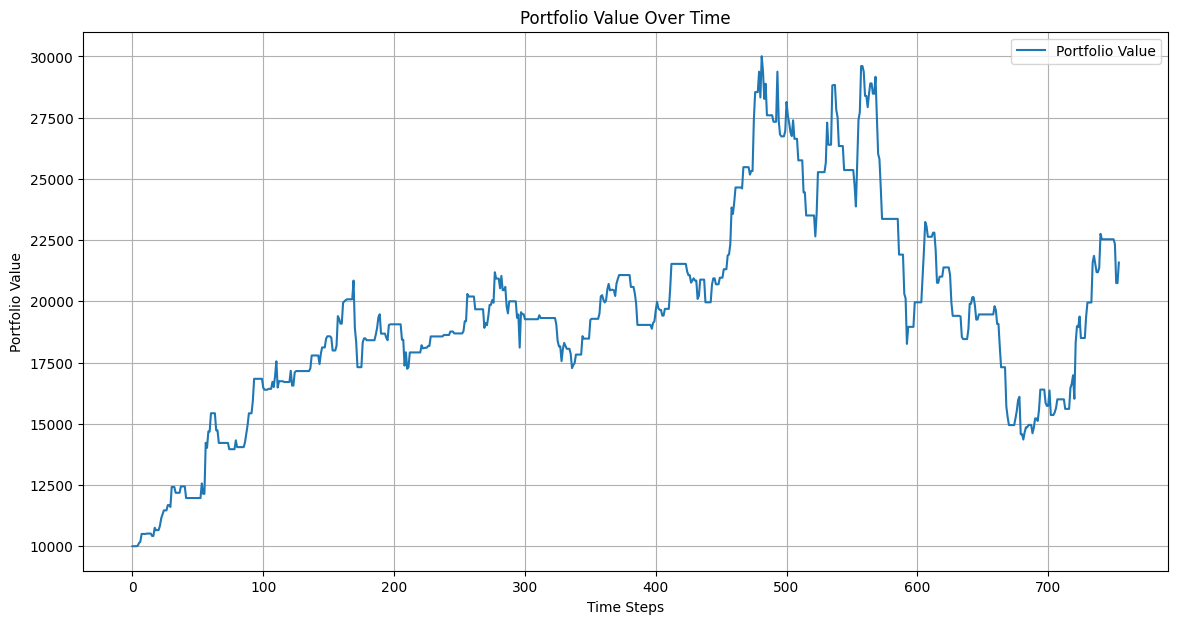

In [17]:
# Convert history to DataFrame
history_df = pd.DataFrame(history)

# Calculate additional metrics
returns = history_df['total_value'].pct_change().dropna()
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
volatility = returns.std() * np.sqrt(252)
max_drawdown = history_df['total_value'].max() - history_df['total_value'].min()
sortino_ratio = returns.mean() / returns[returns < 0].std() * np.sqrt(252)
calmar_ratio = returns.mean() / max_drawdown * np.sqrt(252)

# Print the results
print(f"Total Test Reward: {total_reward}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f} (Higher is better, indicates risk-adjusted return)")
print(f"Volatility: {volatility:.4f} (Lower is better, indicates stability)")
print(f"Maximum Drawdown: {max_drawdown:.4f} (Lower is better, indicates lower risk of large losses)")
print(f"Sortino Ratio: {sortino_ratio:.4f} (Higher is better, focuses on downside risk-adjusted return)")
print(f"Calmar Ratio: {calmar_ratio:.4f} (Higher is better, indicates return relative to drawdown)")

# Visualize the results using a plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(history_df['total_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


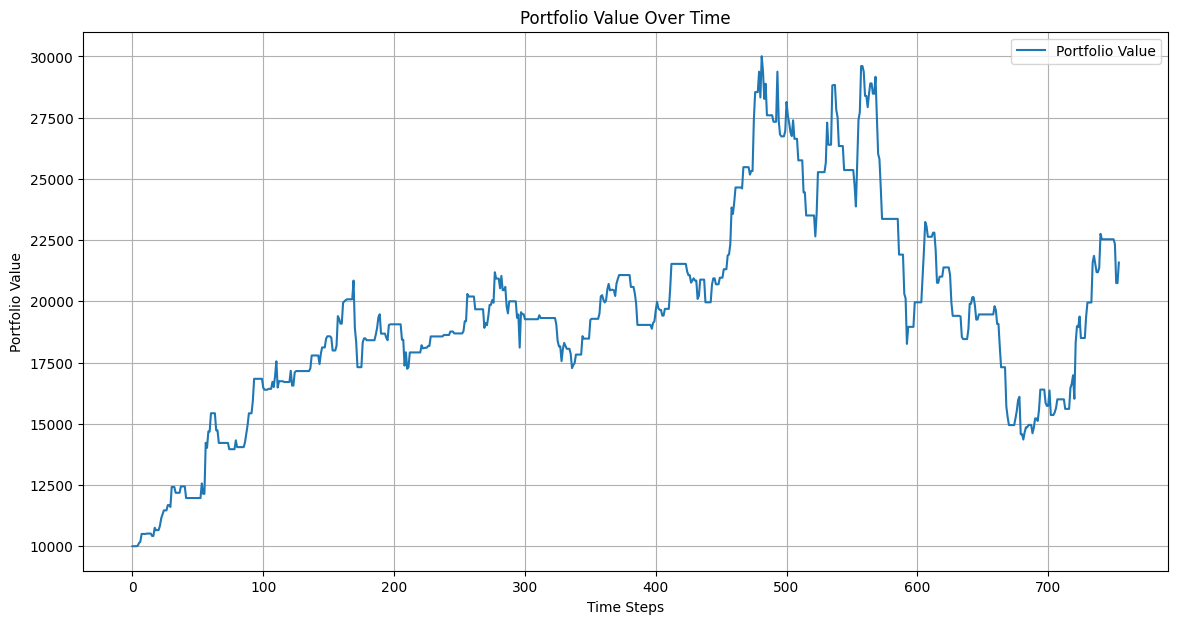

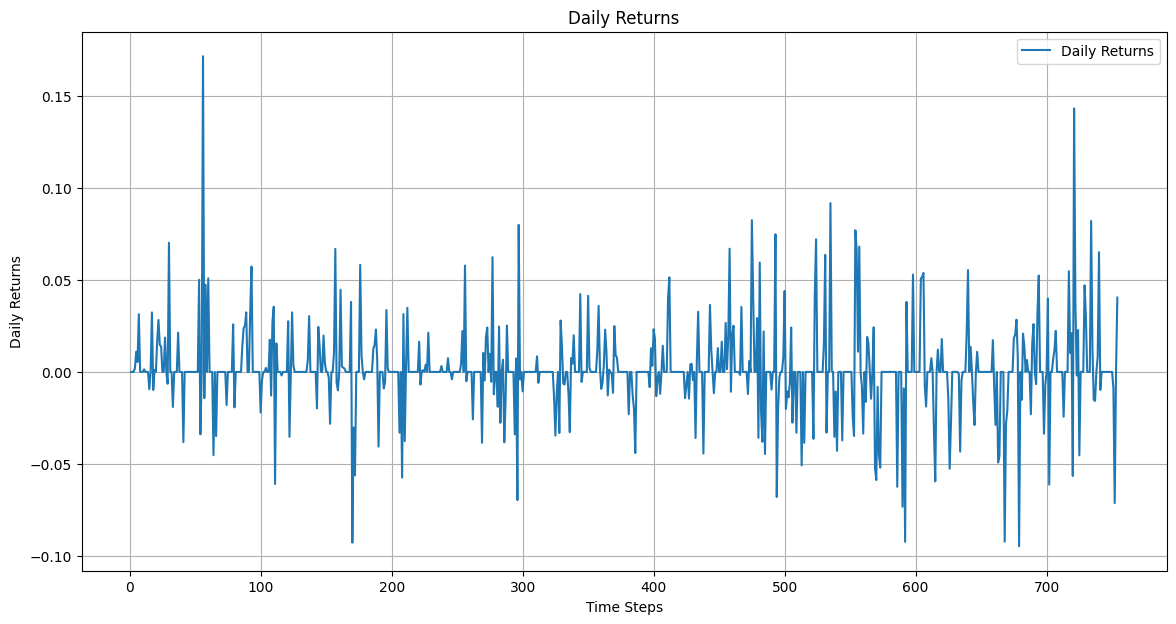

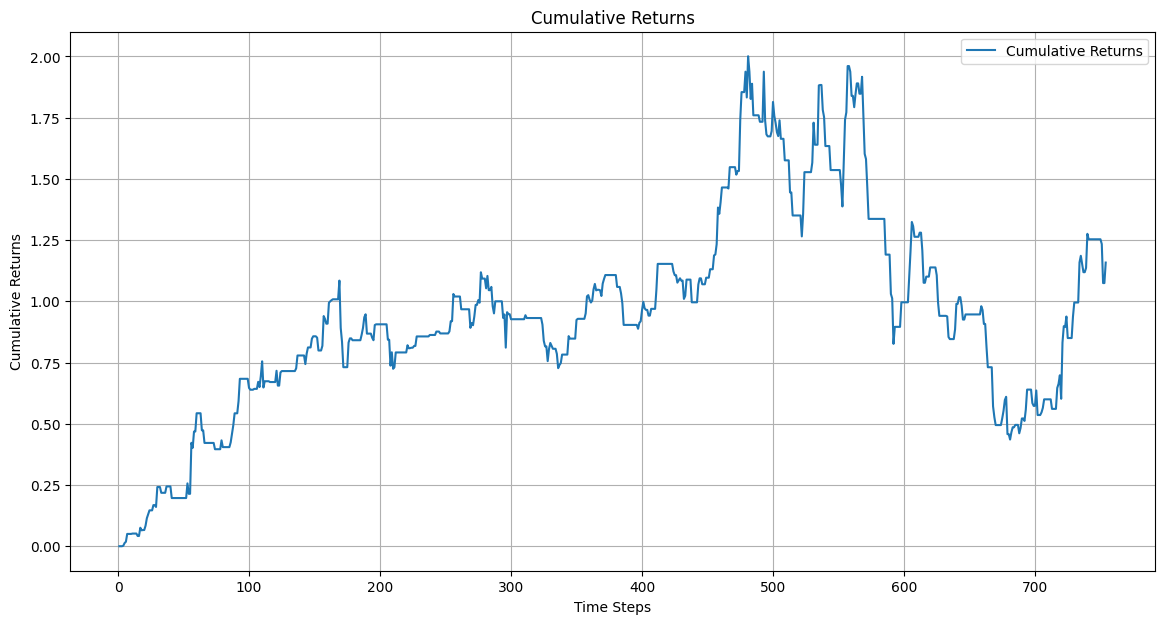

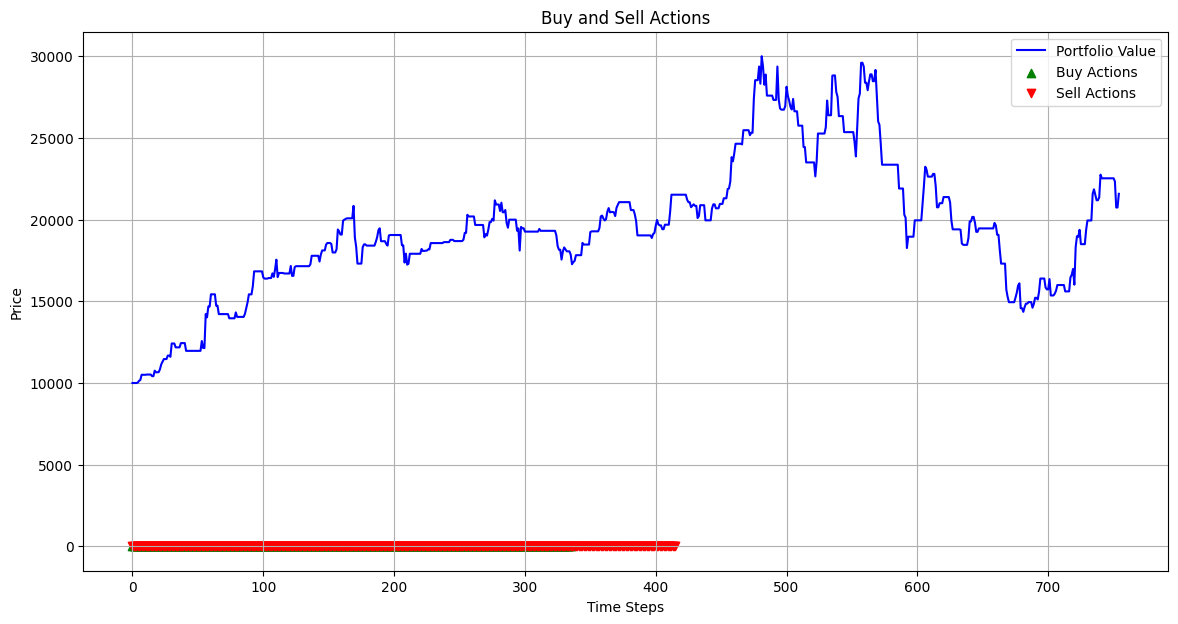

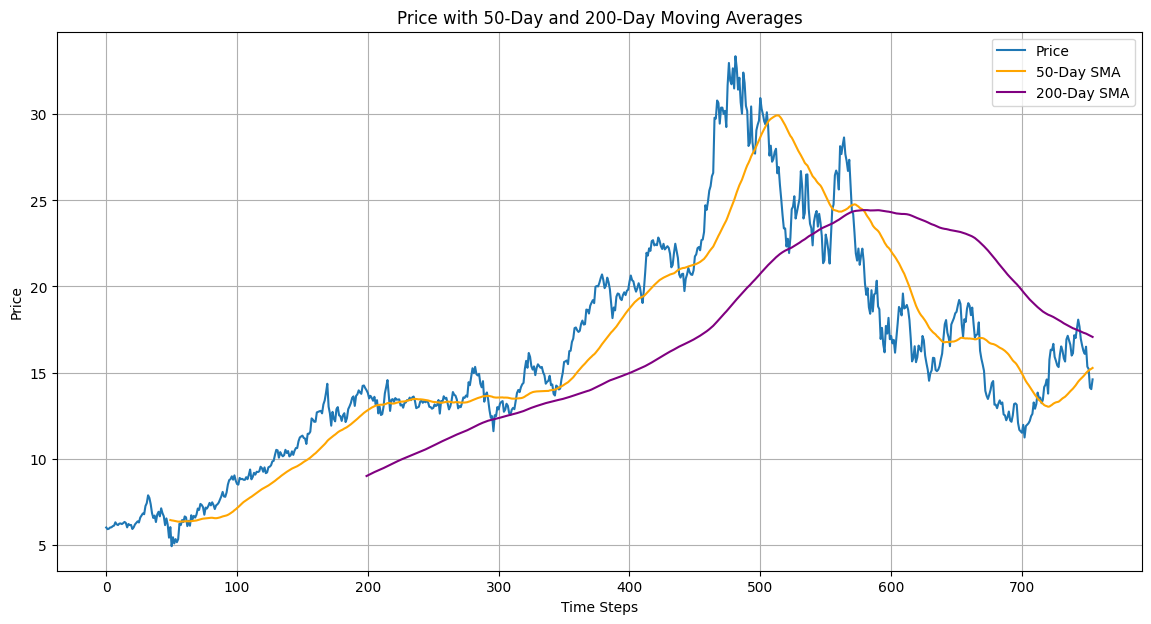

In [18]:
import matplotlib.pyplot as plt

# Ensure history_df is a DataFrame
history_df = pd.DataFrame(history)

# Calculate returns and cumulative returns
history_df['returns'] = history_df['total_value'].pct_change().dropna()
history_df['cumulative_returns'] = (1 + history_df['returns']).cumprod() - 1

# Plot Portfolio Value Over Time
plt.figure(figsize=(14, 7))
plt.plot(history_df['total_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot Daily Returns
plt.figure(figsize=(14, 7))
plt.plot(history_df['returns'], label='Daily Returns')
plt.title('Daily Returns')
plt.xlabel('Time Steps')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot Cumulative Returns
plt.figure(figsize=(14, 7))
plt.plot(history_df['cumulative_returns'], label='Cumulative Returns')
plt.title('Cumulative Returns')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot Buy/Sell Actions
buy_sell_actions = [action['price'] for action in history if action['price'] > 0]
buy_actions = [action for action in history if action['holdings'] > 0]
sell_actions = [action for action in history if action['holdings'] == 0 and action['balance'] > 10000]

plt.figure(figsize=(14, 7))
plt.plot(history_df['total_value'], label='Portfolio Value', color='blue')
plt.scatter([i for i in range(len(buy_actions))], [action['price'] for action in buy_actions], label='Buy Actions', marker='^', color='green')
plt.scatter([i for i in range(len(sell_actions))], [action['price'] for action in sell_actions], label='Sell Actions', marker='v', color='red')
plt.title('Buy and Sell Actions')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot Moving Averages
history_df['SMA50'] = history_df['price'].rolling(window=50).mean()
history_df['SMA200'] = history_df['price'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(history_df['price'], label='Price')
plt.plot(history_df['SMA50'], label='50-Day SMA', color='orange')
plt.plot(history_df['SMA200'], label='200-Day SMA', color='purple')
plt.title('Price with 50-Day and 200-Day Moving Averages')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


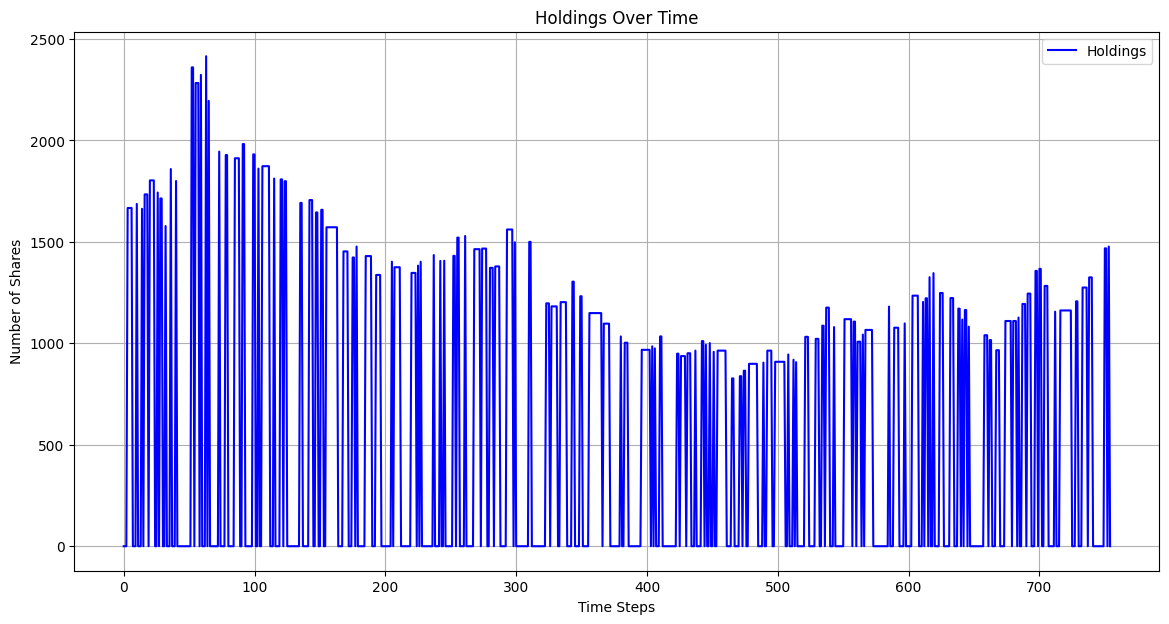

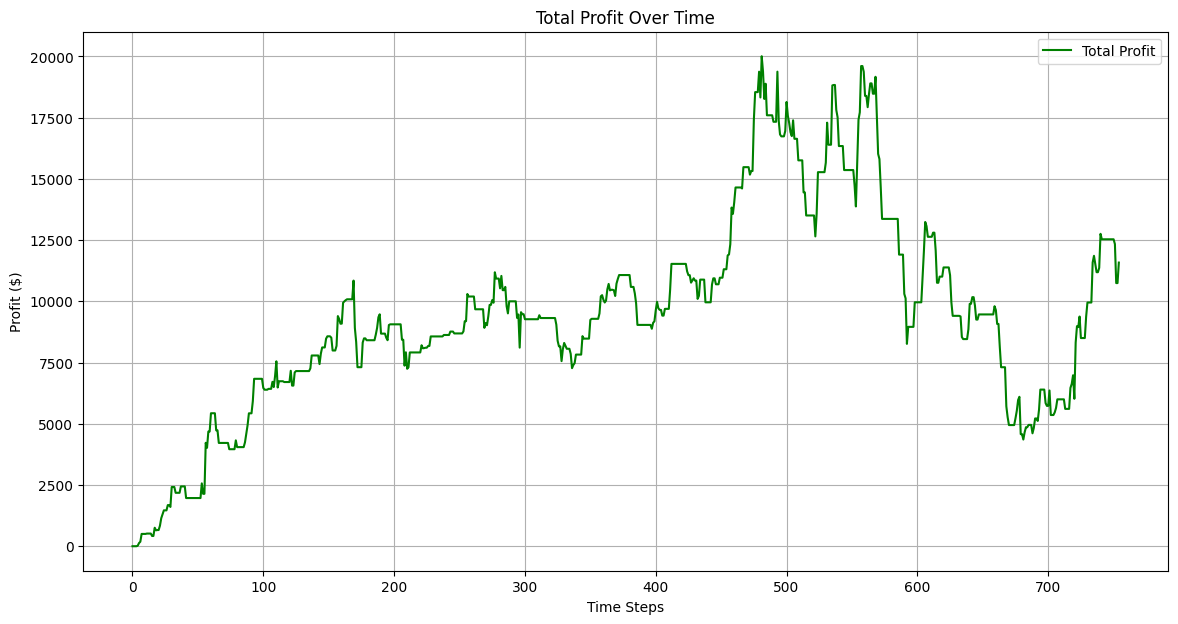

In [19]:
import matplotlib.pyplot as plt

# Ensure history_df is a DataFrame
history_df = pd.DataFrame(history)

# Calculate cumulative profit
history_df['profit'] = history_df['total_value'] - 10000

# Plot Holdings Over Time
plt.figure(figsize=(14, 7))
plt.plot(history_df.index, history_df['holdings'], label='Holdings', color='blue')
plt.title('Holdings Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Shares')
plt.legend()
plt.grid(True)
plt.show()

# Plot Total Profit Over Time
plt.figure(figsize=(14, 7))
plt.plot(history_df.index, history_df['profit'], label='Total Profit', color='green')
plt.title('Total Profit Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit ($)')
plt.legend()
plt.grid(True)
plt.show()
